In [124]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
tsla_df = yf.download('TSLA')

[*********************100%***********************]  1 of 1 completed


In [3]:
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
tsla_pd = pd.DataFrame(tsla_df)

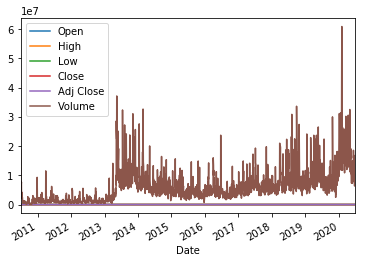

In [6]:
tsla_pd.plot()

In [14]:
#Chop up

In [9]:
#If you want to chop up the dataframe
#cols = ['Open','Close', 'Volume']
#tsla_2020_pd = pd.DataFrame(tsla_pd[cols])
#tsla_2020_pd = tsla_2020_pd.loc['2020-1-1':'2020-7-1']

In [13]:
tsla_2020_pd.tail()

,Open,Close,Volume
Date,,,
2020-01-02,424.500000,430.260010,9532100
2020-01-03,440.500000,443.010010,17778500
2020-01-06,440.470001,451.540009,10133000
2020-01-07,461.399994,469.059998,17882100
2020-01-08,473.700012,492.140015,31144300


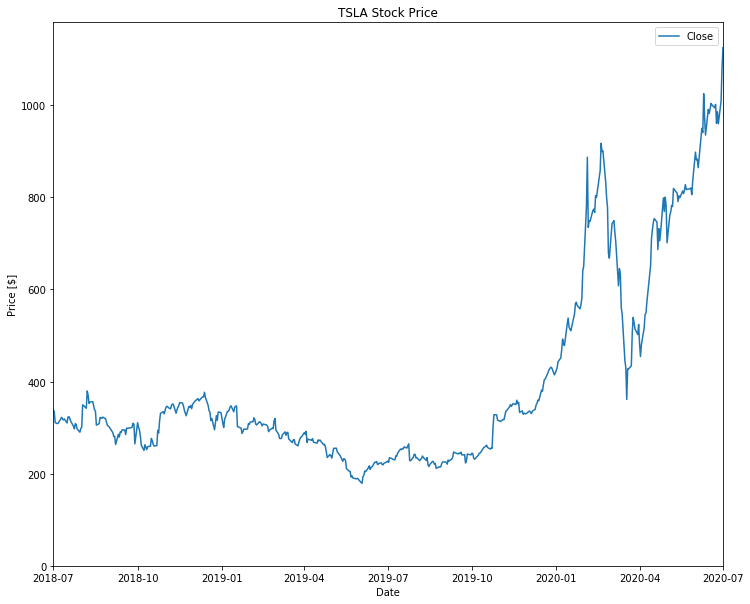

In [43]:
#tsla_2020_pd['Close'].plot()
plt.figure(figsize=(12,10))
plt.plot(tsla_pd.index, tsla_pd['Close'])
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.title("TSLA Stock Price")
plt.ylim(bottom=0)
plt.xlim(["2018-7-1", "2020-7-1"])
plt.legend()
plt.show()

In [69]:
tsla_pd["SMA2"] = tsla_pd['Close'].rolling(window=2).mean()
tsla_pd["SMA5"] = tsla_pd['Close'].rolling(window=5).mean()
tsla_pd["SMA10"] = tsla_pd['Close'].rolling(window=10).mean()
tsla_pd["SMA25"] = tsla_pd['Close'].rolling(window=25).mean()
tsla_pd["SMA50"] = tsla_pd['Close'].rolling(window=50).mean()
tsla_pd["SMA90"] = tsla_pd['Close'].rolling(window=90).mean()
tsla_pd["SMA120"] = tsla_pd['Close'].rolling(window=120).mean()
tsla_pd["SMA180"] = tsla_pd['Close'].rolling(window=180).mean()

In [70]:
tsla_pd.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA50,middle_band,upper_band,lower_band,EWMA,SMA2,SMA5,SMA25,SMA90,SMA120,SMA180
Date,,,,,,,,,,,,,,,,,,
2020-06-25,954.270020,985.979980,937.150024,985.979980,985.979980,9254500,984.789008,847.657401,949.201505,1060.674276,837.728733,982.164140,973.414978,988.766003,922.936802,742.785111,714.611668,589.002057
2020-06-26,994.780029,995.000000,954.869995,959.739990,959.739990,8854900,987.235004,851.948000,955.438504,1053.111882,857.765126,965.346028,972.859985,980.533997,928.222402,743.255333,718.846667,592.975445
2020-06-29,969.010010,1010.000000,948.520020,1009.349976,1009.349976,9026400,989.079999,857.057200,961.001004,1057.590568,864.411440,998.348989,984.544983,983.539990,935.921201,744.476889,723.349084,597.223279
2020-06-30,1006.500000,1087.689941,1003.729980,1079.810059,1079.810059,16881600,998.848004,863.726201,970.913507,1073.670141,868.156874,1059.444791,1044.580017,999.145996,946.358804,746.463667,728.246334,601.845057
2020-07-01,1083.000000,1135.329956,1080.500000,1124.830200,1124.830200,7987181,1012.152026,872.488406,983.007016,1098.341195,867.672837,1108.483848,1102.320129,1031.942041,958.542812,749.697447,733.608753,606.666558


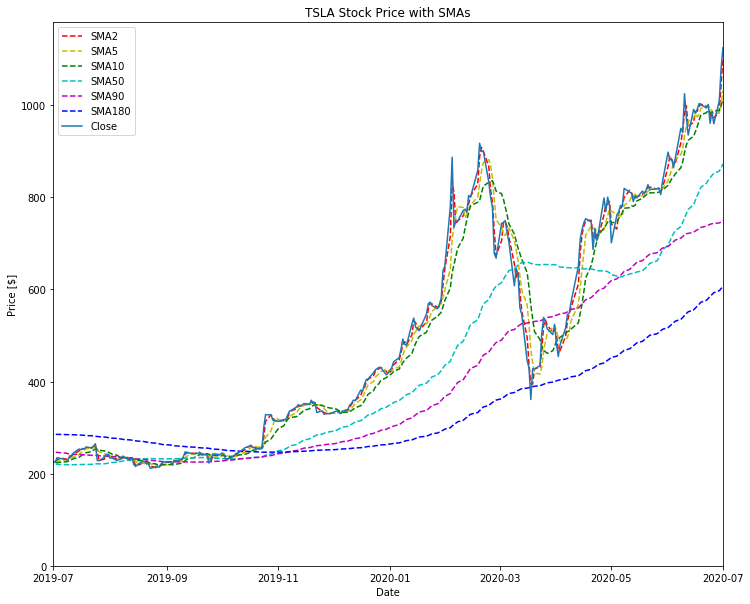

In [78]:
plt.figure(figsize=(12,10))
plt.plot(tsla_pd['SMA2'], 'r--', label="SMA2")
plt.plot(tsla_pd['SMA5'], 'y--', label="SMA5")
plt.plot(tsla_pd['SMA10'], 'g--', label="SMA10")
plt.plot(tsla_pd['SMA50'], 'c--', label="SMA50")
plt.plot(tsla_pd['SMA90'], 'm--', label="SMA90")
plt.plot(tsla_pd['SMA180'], 'b--', label="SMA180")
plt.plot(tsla_pd['Close'], label="Close")
plt.title("TSLA Stock Price with SMAs")
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.ylim(bottom=0)
plt.xlim(["2019-7-1", "2020-7-1"])
plt.legend()
plt.show()

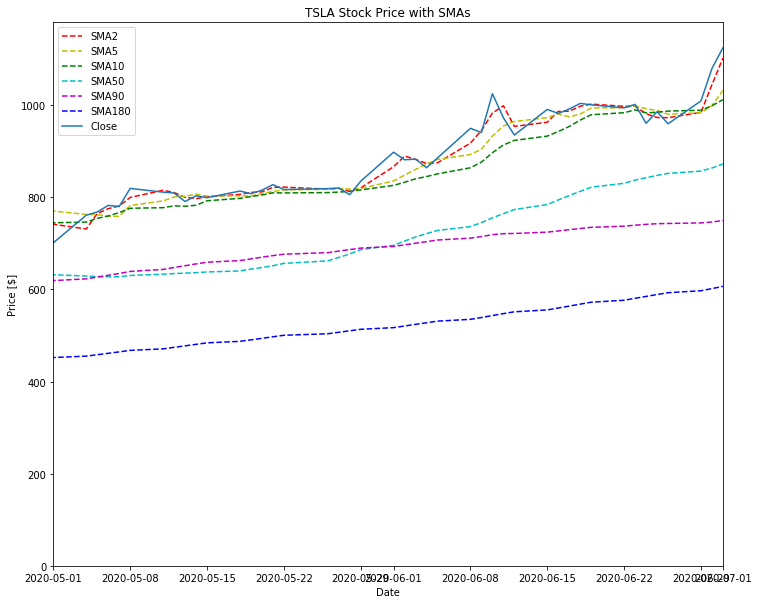

In [98]:
plt.figure(figsize=(12,10))
plt.plot(tsla_pd['SMA2'], 'r--', label="SMA2")
plt.plot(tsla_pd['SMA5'], 'y--', label="SMA5")
plt.plot(tsla_pd['SMA10'], 'g--', label="SMA10")
plt.plot(tsla_pd['SMA50'], 'c--', label="SMA50")
plt.plot(tsla_pd['SMA90'], 'm--', label="SMA90")
plt.plot(tsla_pd['SMA180'], 'b--', label="SMA180")
plt.plot(tsla_pd['Close'], label="Close")
plt.title("TSLA Stock Price with SMAs")
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.ylim(bottom=0)
plt.xlim(["2020-5-1", "2020-7-1"])
plt.legend()
plt.show()

In [61]:
#Bollinger Bands
tsla_pd['EWMA'] = tsla_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
tsla_pd['middle_band'] = tsla_pd['Close'].rolling(window=20).mean()
tsla_pd['upper_band'] = tsla_pd['Close'].rolling(window=20).mean() + tsla_pd['Close'].rolling(window=20).std()*2
tsla_pd['lower_band'] = tsla_pd['Close'].rolling(window=20).mean() - tsla_pd['Close'].rolling(window=20).std()*2

In [66]:
#tsla_pd = tsla_pd.drop(columns='EWMA-0_5-20')
tsla_pd.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA50,middle_band,upper_band,lower_band,EWMA
Date,,,,,,,,,,,,
2020-06-25,954.270020,985.979980,937.150024,985.979980,985.979980,9254500,984.789008,847.657401,949.201505,1060.674276,837.728733,982.164140
2020-06-26,994.780029,995.000000,954.869995,959.739990,959.739990,8854900,987.235004,851.948000,955.438504,1053.111882,857.765126,965.346028
2020-06-29,969.010010,1010.000000,948.520020,1009.349976,1009.349976,9026400,989.079999,857.057200,961.001004,1057.590568,864.411440,998.348989
2020-06-30,1006.500000,1087.689941,1003.729980,1079.810059,1079.810059,16881600,998.848004,863.726201,970.913507,1073.670141,868.156874,1059.444791
2020-07-01,1083.000000,1135.329956,1080.500000,1124.830200,1124.830200,7987181,1012.152026,872.488406,983.007016,1098.341195,867.672837,1108.483848


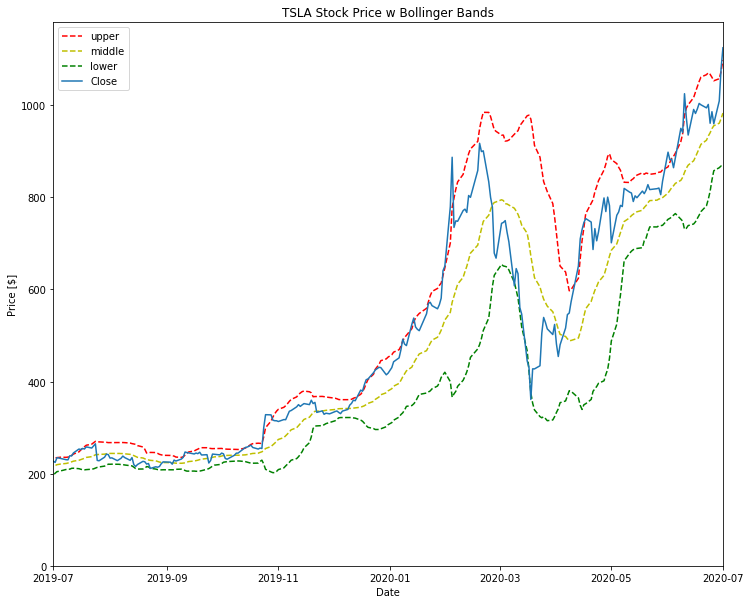

In [100]:
plt.figure(figsize=(12,10))
plt.plot(tsla_pd['upper_band'], 'r--', label="upper")
plt.plot(tsla_pd['middle_band'], 'y--', label="middle")
plt.plot(tsla_pd['lower_band'], 'g--', label="lower")
plt.plot(tsla_pd['Close'], label="Close")
plt.title("TSLA Stock Price w Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.ylim(bottom=0)
plt.xlim(["2019-7-1", "2020-7-1"])
plt.legend()
plt.show()

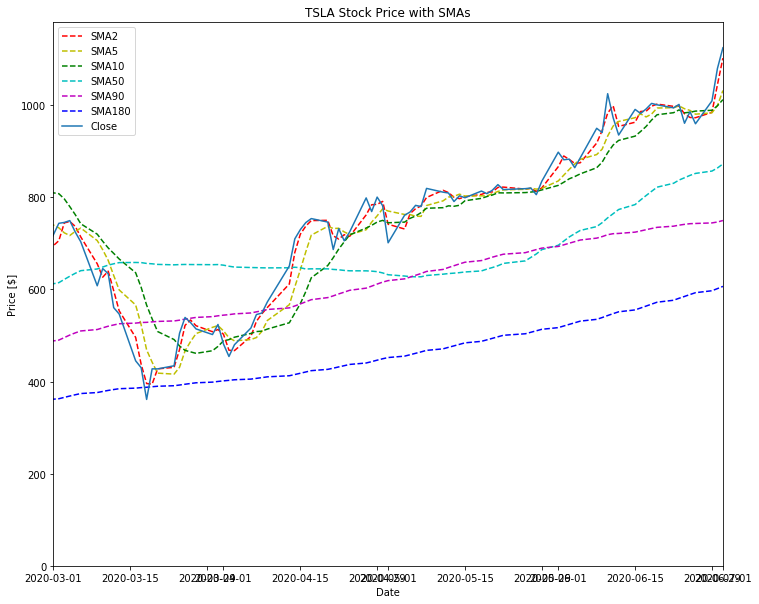

In [80]:
plt.figure(figsize=(12,10))
plt.plot(tsla_pd['SMA2'], 'r--', label="SMA2")
plt.plot(tsla_pd['SMA5'], 'y--', label="SMA5")
plt.plot(tsla_pd['SMA10'], 'g--', label="SMA10")
plt.plot(tsla_pd['SMA50'], 'c--', label="SMA50")
plt.plot(tsla_pd['SMA90'], 'm--', label="SMA90")
plt.plot(tsla_pd['SMA180'], 'b--', label="SMA180")
plt.plot(tsla_pd['Close'], label="Close")
plt.title("TSLA Stock Price with SMAs")
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.ylim(bottom=0)
plt.xlim(["2020-3-1", "2020-7-1"])
plt.legend()
plt.show()

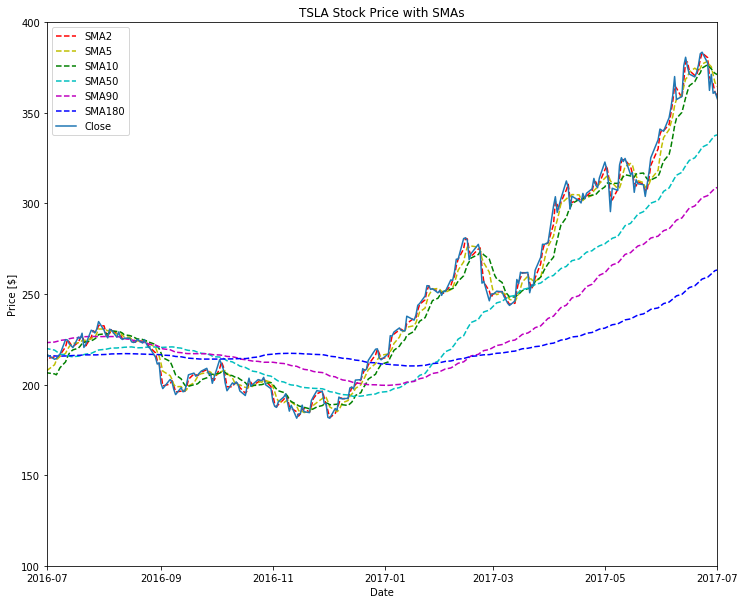

In [97]:
plt.figure(figsize=(12,10))
plt.plot(tsla_pd['SMA2'], 'r--', label="SMA2")
plt.plot(tsla_pd['SMA5'], 'y--', label="SMA5")
plt.plot(tsla_pd['SMA10'], 'g--', label="SMA10")
plt.plot(tsla_pd['SMA50'], 'c--', label="SMA50")
plt.plot(tsla_pd['SMA90'], 'm--', label="SMA90")
plt.plot(tsla_pd['SMA180'], 'b--', label="SMA180")
plt.plot(tsla_pd['Close'], label="Close")
plt.title("TSLA Stock Price with SMAs")
plt.xlabel("Date")
plt.ylabel("Price [$]")
plt.ylim(bottom=100,top=400)
plt.xlim(["2016-7-1", "2017-7-1"])
plt.legend()
plt.show()

In [193]:
def enrich_stock_with_smas(stock_pd):
    stock_pd["SMA2"] = stock_pd['Close'].rolling(window=2).mean()
    stock_pd["SMA5"] = stock_pd['Close'].rolling(window=5).mean()
    stock_pd["SMA10"] = stock_pd['Close'].rolling(window=10).mean()
    stock_pd["SMA25"] = stock_pd['Close'].rolling(window=25).mean()
    stock_pd["SMA50"] = stock_pd['Close'].rolling(window=50).mean()
    stock_pd["SMA90"] = stock_pd['Close'].rolling(window=90).mean()
    stock_pd["SMA120"] = stock_pd['Close'].rolling(window=120).mean()
    stock_pd["SMA180"] = stock_pd['Close'].rolling(window=180).mean()
    e_stock_pd = stock_pd
    return e_stock_pd

def enrich_stock_with_bbs(stock_pd):
    #Bollinger Bands
    stock_pd['EWMA'] = stock_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
    stock_pd['middle_band'] = stock_pd['Close'].rolling(window=20).mean()
    stock_pd['upper_band'] = stock_pd['Close'].rolling(window=20).mean() + stock_pd['Close'].rolling(window=20).std()*2
    stock_pd['lower_band'] = stock_pd['Close'].rolling(window=20).mean() - stock_pd['Close'].rolling(window=20).std()*2
    e_stock_pd = stock_pd
    return e_stock_pd

def print_sma_chart_days(stock_pd, nDays):
    dt_latest = stock_pd.iloc[-1:].index[0]
    dt_previous = dt_latest - timedelta(days=nDays)
    
    plt.figure(figsize=(12,10))
    plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    plt.plot(stock_pd['Close'], label="Close")
    plt.title("Stock Price with SMAs from ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"]")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous.strftime("%Y-%m-%d"), dt_latest.strftime("%Y-%m-%d")])
    plt.legend()
    plt.show()

def last_stock_date(stock_pd):
    return stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    
def first_stock_date(stock_pd):
    return stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")

def save_dataframe_as_csv(stock_pd,stock_ticker):
    stock_file_name = stock_ticker+"_"+stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")+"_"+stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")+".csv"
    stock_pd.to_csv(r''+stock_file_name)
    print("Saved as: ["+ stock_file_name+"]")

def convert_df_to_pd(stock_df):
    stock_pd = pd.DataFrame(stock_df)
    return stock_pd

def process_stock_once(stock_ticker):
    stock_df = yf.download(stock_ticker)
    stock_pd = convert_df_to_pd(stock_df)
    save_dataframe_as_csv(stock_pd,stock_ticker)
    stock_pd = enrich_stock_with_smas(stock_pd)
    stock_pd = enrich_stock_with_bbs(stock_pd)
    print_sma_chart_days(stock_pd,90)
    

In [184]:
### RUN ONCE PER STOCK TICKER
stock_ticker = 'AAPL'
stock_df = yf.download(stock_ticker)
stock_pd = convert_df_to_pd(stock_df)
save_dataframe_as_csv(stock_pd,stock_ticker)

[*********************100%***********************]  1 of 1 completed
Saved as: [AAPL_1980-12-12_2020-07-01.csv]


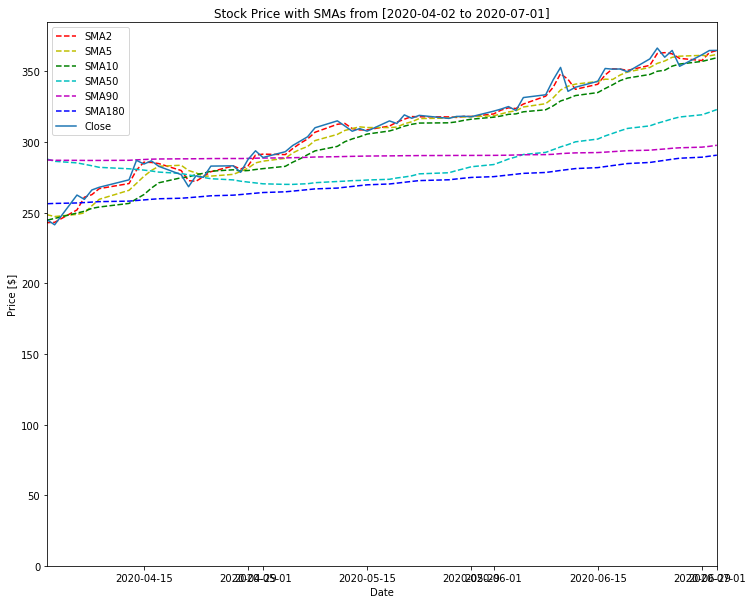

In [185]:
### EXPERIMENTAL
stock_pd = enrich_stock_with_smas(stock_pd)
stock_pd = enrich_stock_with_bbs(stock_pd)
print_sma_chart_days(stock_pd,90)

In [176]:
### EXPERIMENTAL 
print(last_stock_date(stock_pd))
print(first_stock_date(stock_pd))

2020-07-01
1980-12-12


In [186]:
stock_pd.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA2,SMA5,SMA10,SMA25,SMA50,SMA90,SMA120,SMA180,EWMA,middle_band,upper_band,lower_band
Date,,,,,,,,,,,,,,,,,,
2020-06-25,360.700012,365.000000,357.570007,364.839996,364.839996,34380600,362.449997,360.003998,353.720996,337.371998,316.388199,295.598665,300.730999,287.842777,363.895747,342.273497,372.843217,311.703777
2020-06-26,364.410004,365.320007,353.019989,353.630005,353.630005,51314200,359.235001,360.785999,355.203998,338.843198,317.727000,295.932110,301.179583,288.546110,356.196440,344.057997,372.756335,315.359659
2020-06-29,353.250000,362.170013,351.279999,361.779999,361.779999,32661500,357.705002,361.367999,357.082999,340.558798,319.306600,296.392999,301.707833,289.277722,360.384109,346.054497,373.787163,318.321831
2020-06-30,360.079987,365.980011,360.000000,364.799988,364.799988,35024100,363.289993,361.021997,358.354999,342.481597,321.064000,296.967999,302.221249,289.992110,363.696018,348.127496,374.892466,321.362527
2020-07-01,365.119995,367.359985,363.910004,364.890015,364.890015,23237532,364.845001,361.988000,359.685001,344.352798,322.994400,297.709221,302.681749,290.708888,364.591516,350.115997,375.560596,324.671398


[*********************100%***********************]  1 of 1 completed
Saved as: [TSLA_2010-06-29_2020-07-01.csv]


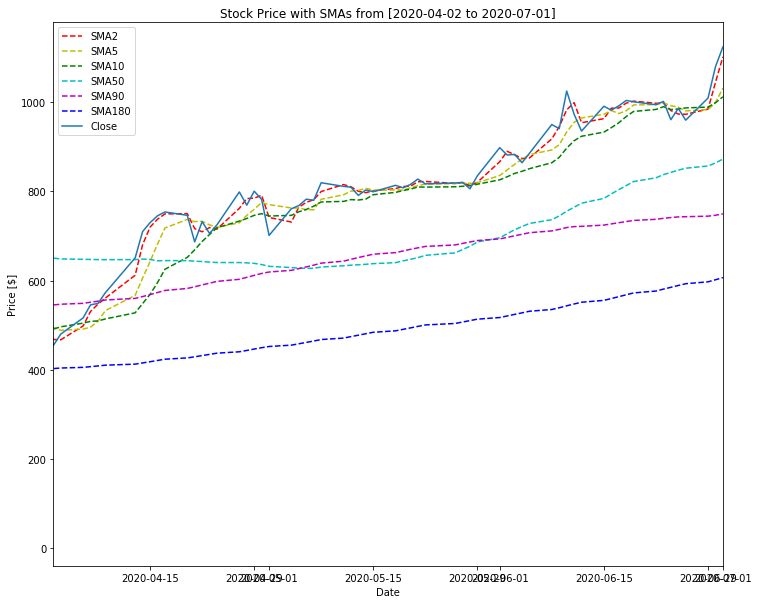

In [195]:
### PRODUCTION EXPERIMENTATION
ticker_name = 'TSLA'
process_stock_once(ticker_name)

[*********************100%***********************]  1 of 1 completed
Saved as: [TSLA_2010-06-29_2020-07-01.csv]


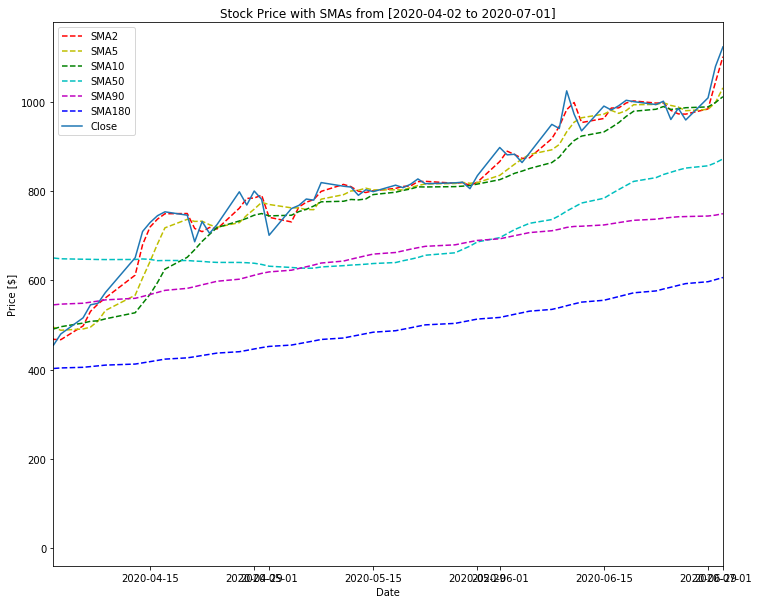

[*********************100%***********************]  1 of 1 completed
Saved as: [GOOG_2004-08-19_2020-07-01.csv]


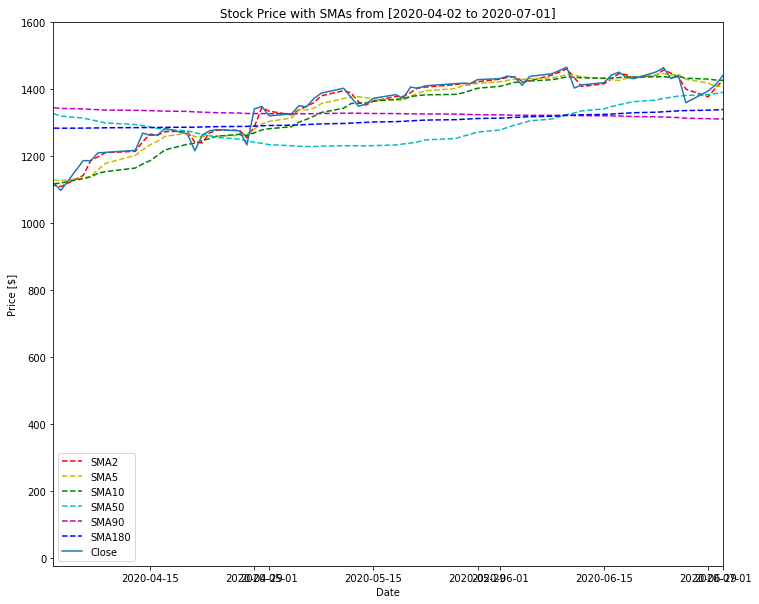

[*********************100%***********************]  1 of 1 completed
Saved as: [AMZN_1997-05-15_2020-07-01.csv]


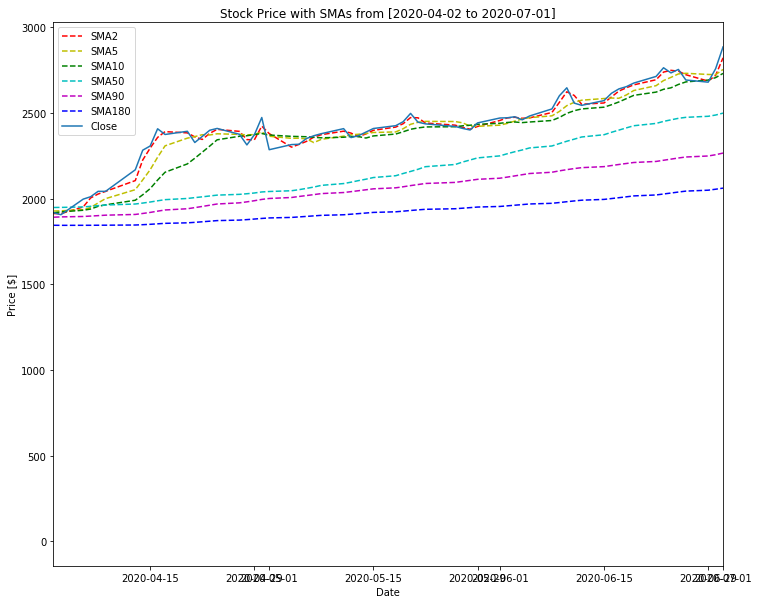

In [194]:
### PRODUCTION EXPERIMENTATION
ticker_name = 'TSLA'
process_stock_once(ticker_name)
ticker_name = 'GOOG'
process_stock_once(ticker_name)
ticker_name = 'AMZN'
process_stock_once(ticker_name)